# Exploration of Sales Data

Snohomish County Parcel Search:  
https://www.snoco.org/proptax/search.aspx?parcel_number= ***PARCELHERE***


In [210]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations

### Data from Mongo Database

In [2]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

In [3]:
db = client['homesales_snohomish']
sales = db.homesales

In [4]:
rows = sales.find()
home_sales = pd.DataFrame(list(rows))
home_sales = home_sales.drop('_id', axis=1)

In [5]:
len(home_sales['Parcel #'].unique())

2090

### Data from csv

In [6]:
# home_sales1 = pd.read_csv(
#     'data/sales.csv',
#     index_col=0,
#     dtype={
#         'Parcel #': str,
#         'Year Built': str,
#         'Type': str,
#         'Quality/Grade': str,
#         'Address': str,
#         'City': str,
#         'Nbhd': str
#     }
# )

## Initial inspection

In [7]:
home_sales.head()

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
0,31051100400500,1/31/2020 12:00:00 AM,"$2,500,000.00",5.44,,,,,21015 STATE ROUTE 9 NE,Arlington,Nbhd:5203000,521
1,00804500000100,1/31/2020 12:00:00 AM,"$416,000.00",0.29,1993,Tri Level,Avg,1430,20911 66TH AVE NE,Arlington,Nbhd:2408000,111
2,00960009607300,1/31/2020 12:00:00 AM,"$75,000.00",0,1996,Dbl Wide,V Good,1620,20227 80TH AVE NE SPC 73,Arlington,Nbhd:2408906,119
3,00874800005200,1/29/2020 12:00:00 AM,"$419,000.00",0.14,2001,1 1/2 Sty,Avg,1813,18127 GREYWALLS DR,Arlington,Nbhd:2408000,111
4,00946600000300,1/29/2020 12:00:00 AM,"$347,000.00",0.1166,2003,1 Sty,Avg-,1348,18722 35TH AVE NE,,Nbhd:2408000,111


In [8]:
home_sales.shape

(2248, 12)

In [9]:
len(home_sales['Parcel #'].unique())

2090

## Data Cleaning

### Filters

#### Dates 

In [10]:
# ********** Clean Dates ***************
datetime.datetime.strptime(
    home_sales['Date of Sale'][0], '%m/%d/%Y %H:%M:%S %p')

datetime.datetime(2020, 1, 31, 12, 0)

In [11]:
def date_clean(d):
    return datetime.datetime.strptime(d, '%m/%d/%Y %H:%M:%S %p')

In [12]:
home_sales['Date of Sale'] = home_sales['Date of Sale'].map(date_clean)

#### Price

In [13]:
# ********** Clean Sale Price **********
def sale_price_clean(price):
    return float(price.strip('$').replace(',',''))

In [14]:
sale_price_clean(home_sales['Sale Price'][0])

2500000.0

In [15]:
home_sales['Sale Price'] = home_sales['Sale Price'].map(sale_price_clean)

#### Use Code, Sqft, Lot Size, 

In [16]:
home_sales['Use Code'] = home_sales['Use Code'].map(int)

In [31]:
def sqft_clean(sqft):
    if sqft:
        return int(sqft)
    else:
        return None

In [32]:
home_sales['Sqft'] = home_sales['Sqft'].map(sqft_clean)

In [59]:
home_sales['Lot Size'] = home_sales['Lot Size'].map(float)

In [67]:
def year_built_clean(year):
    if year:
        return int(year)
    else:
        return None

In [69]:
home_sales['Year Built'] = home_sales['Year Built'].map(year_built_clean)

#### Neighborhood

In [19]:
home_sales['Nbhd'][0].split(':')[1]

'5203000'

In [20]:
home_sales['Nbhd'] = home_sales['Nbhd'].map(lambda n: n.split(':')[1])

### Remove bad data

In [85]:
# Removing rows where Year Built is greater than current year
home_sales.drop(home_sales[home_sales['Year Built'] > 2021].index, inplace=True)

## Looking at data

In [21]:
np.sort(home_sales['Use Code'].unique())

array([110, 111, 112, 116, 117, 118, 119, 121, 122, 123, 124, 130, 131,
       136, 141, 142, 143, 145, 160, 179, 183, 184, 185, 186, 188, 198,
       249, 344, 349, 431, 461, 502, 511, 519, 521, 539, 553, 559, 581,
       591, 599, 615, 623, 629, 637, 639, 641, 651, 661, 691, 699, 723,
       744, 830, 860, 880, 910, 911, 912, 913, 914, 940, 941, 950])

In [22]:
# home_sales[home_sales['Use Code']==118].iloc[0];

In [175]:
use_codes = np.load('data/use_codes.npy', allow_pickle='TRUE').item()

In [104]:
home_sales[home_sales['Use Code']<150].groupby('Use Code')['Use Code'].count()

Use Code
110       7
111    1216
112      18
116      40
117       7
118      61
119      82
121       2
122      19
123       1
124       6
130       2
131       5
136       1
141      82
142      28
143     174
145      33
Name: Use Code, dtype: int64

In [105]:
home_sales[home_sales['Use Code']<150].groupby('Type')['Type'].count()

Type
                46
1 1/2 Sty       46
1 1/2 Sty B     25
1 Sty          551
1 Sty B        109
2 Sty          533
2 Sty B         56
2+ Sty          67
2+ Sty B         1
Dbl Wide       107
Dbl Wide B       1
Multi Level      1
Sgl Wide        50
Split Entry    131
Tri Level       57
Trpl Wide        3
Name: Type, dtype: int64

In [115]:
# home_sales[
#     (home_sales['Use Code']<150) & 
#     (home_sales['Type']=='2+ Sty') & 
#     (home_sales['Use Code']== 111)
# ]


In [24]:
sfr_codes = [111,112,113,116,118,141,142]

In [25]:
type(home_sales['Use Code'][0])

numpy.int64

In [86]:
single_family = home_sales[home_sales['Use Code'].isin(sfr_codes)].copy()

In [87]:
single_family.head(3)

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
1,00804500000100,2020-01-31 12:00:00,416000.0,0.2900,1993.0,Tri Level,Avg,1430.0,20911 66TH AVE NE,Arlington,2408000,111
3,00874800005200,2020-01-29 12:00:00,419000.0,0.1400,2001.0,1 1/2 Sty,Avg,1813.0,18127 GREYWALLS DR,Arlington,2408000,111
4,00946600000300,2020-01-29 12:00:00,347000.0,0.1166,2003.0,1 Sty,Avg-,1348.0,18722 35TH AVE NE,,2408000,111


In [88]:
home_sales['City'].unique()

array(['Arlington', '', 'Bothell', 'Brier', 'Darrington', 'Edmonds',
       'Everett', 'Lynnwood', 'Goldbar', 'Granite Falls', 'Lake Stevens',
       'Marysville', 'Stanwood', 'Mill Creek', 'Monroe',
       'Mountlake Terrace', 'MUKILTEO', 'Snohomish', 'Sultan', 'Woodway',
       'BOT        Bothell'], dtype=object)

## Exploration

In [89]:
single_family['price/sqft'] = single_family['Sale Price']/single_family['Sqft']

In [90]:
single_family.groupby('Use Code').mean()

,Sale Price,Lot Size,Year Built,Sqft,price/sqft
Use Code,,,,,
111,542193.833059,0.703761,1983.080725,2044.532949,280.826318
112,587682.777778,3.189289,1964.944444,1688.222222,462.534616
116,476194.125000,0.050020,2011.925000,1890.450000,255.857618
118,321269.967213,2.148318,1986.672131,1454.116667,224.764762
141,492992.256098,0.002838,2010.000000,1932.195122,257.347414
142,401685.714286,0.000000,2003.964286,1576.392857,258.127814


In [91]:
fonts = {'fontsize':16, 'fontfamily':'serif'}

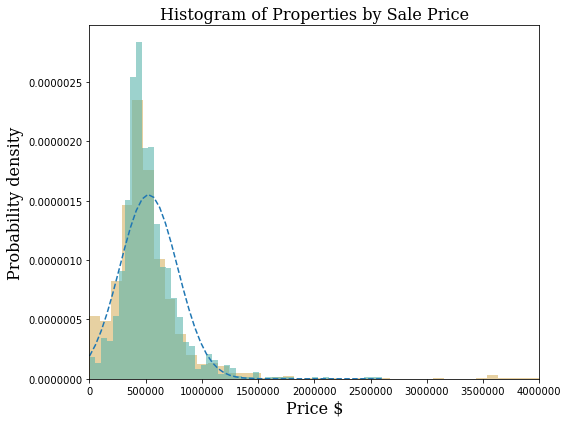

In [92]:
fig, ax = plt.subplots(figsize=(8,6))

mu = single_family['Sale Price'].mean()
std = single_family['Sale Price'].std()

ax.hist(home_sales['Sale Price'], bins=100, density=True, alpha=.6, color='#d8b365')
n, bins, patches = ax.hist(single_family['Sale Price'], bins=50,density=True, color='#5ab4ac', alpha=.6)
fit = stats.norm(loc=mu, scale=std).pdf(bins)
ax.plot(bins,fit,'--')
ax.set_xlim(0,4000000)
ax.set_xlabel('Price $', **fonts)
ax.set_ylabel('Probability density', **fonts)
ax.set_title('Histogram of Properties by Sale Price', **fonts)
ax.ticklabel_format(style='plain')
fig.tight_layout()
plt.show()

In [93]:
mean_per_day = single_family.groupby('Date of Sale')['Sale Price'].mean()

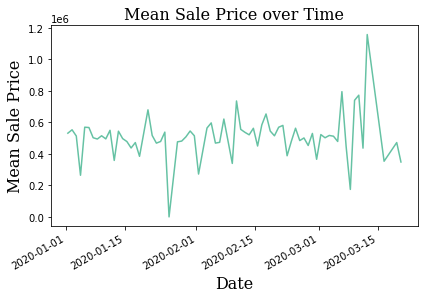

In [94]:
fig, ax = plt.subplots()
ax.plot(mean_per_day, color='#66c2a4')
ax.set_xlabel('Date', **fonts)
ax.set_ylabel('Mean Sale Price', **fonts)
ax.set_title('Mean Sale Price over Time', **fonts)
fig.tight_layout()
fig.autofmt_xdate()
plt.show()

In [95]:
single_family.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1445 entries, 1 to 2247
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Parcel #       1445 non-null   object        
 1   Date of Sale   1445 non-null   datetime64[ns]
 2   Sale Price     1445 non-null   float64       
 3   Lot Size       1445 non-null   float64       
 4   Year Built     1443 non-null   float64       
 5   Type           1445 non-null   object        
 6   Quality/Grade  1445 non-null   object        
 7   Sqft           1442 non-null   float64       
 8   Address        1445 non-null   object        
 9   City           1445 non-null   object        
 10  Nbhd           1445 non-null   object        
 11  Use Code       1445 non-null   int64         
 12  price/sqft     1442 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(6)
memory usage: 158.0+ KB


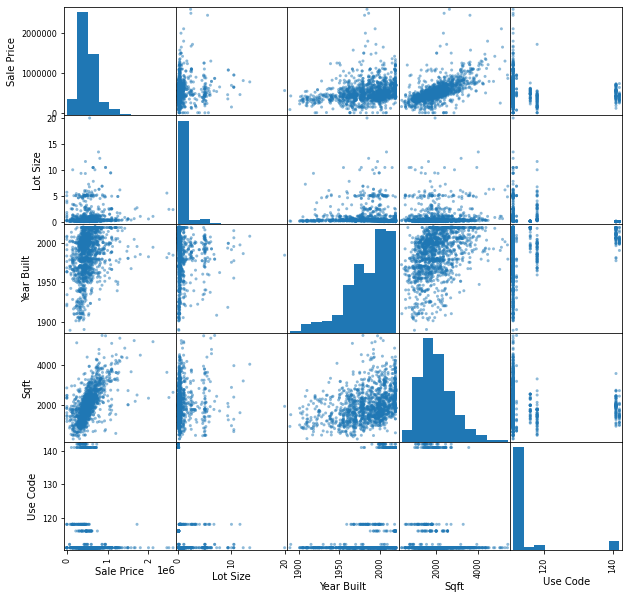

In [114]:
pd.plotting.scatter_matrix(
    single_family[[
        'Date of Sale', 
        'Sale Price',
        'Lot Size',
        'Year Built',
        'Type',
        'Quality/Grade',
        'Sqft',
        'Nbhd',
        'Use Code'
    ]], figsize=(10,10));

In [82]:
home_sales.iloc[home_sales[home_sales['Year Built'] > 2021].index]

,Parcel #,Date of Sale,Sale Price,Lot Size,Year Built,Type,Quality/Grade,Sqft,Address,City,Nbhd,Use Code
2087,27052000205700,2020-03-04 12:00:00,462000.0,0.0502,2103.0,2+ Sty,Avg+,1773.0,2115 201ST PL SE UNIT R-102,,5608000,142


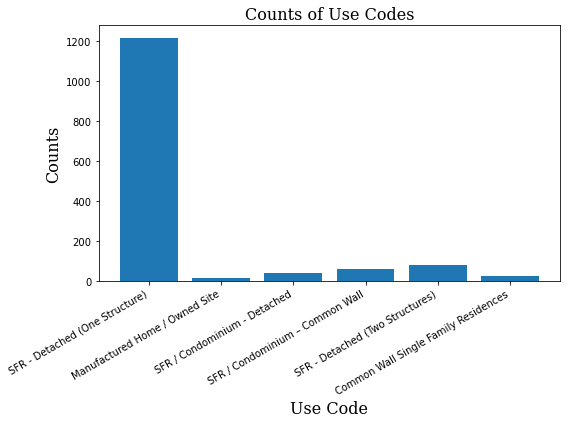

In [133]:
fig, ax = plt.subplots(figsize=(8,6))

ax.bar([use_codes[code] for code in single_family['Use Code'].unique()], 
       single_family.groupby('Use Code')['Use Code'].value_counts())

ax.set_xlabel('Use Code', **fonts)
ax.set_ylabel('Counts', **fonts)
ax.set_title('Counts of Use Codes', **fonts)

fig.autofmt_xdate()
fig.tight_layout()
plt.show()

In [134]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 
     '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', 
     '#bcbd22', '#17becf']
colors = c + c

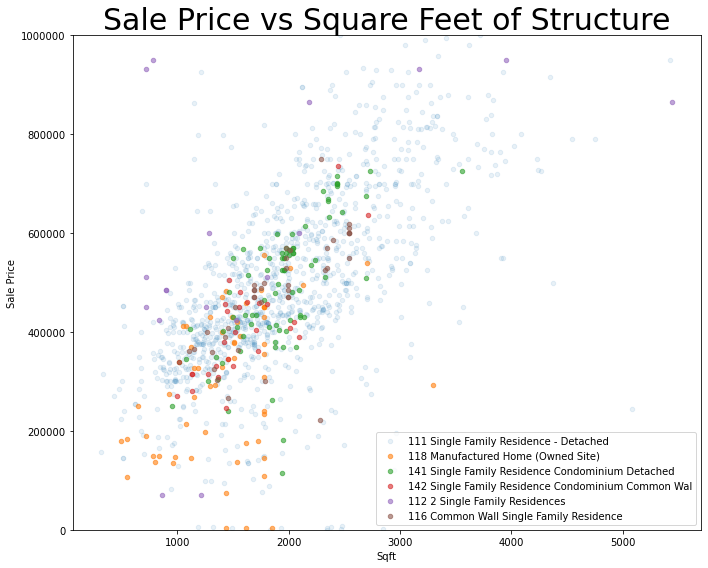

In [185]:
codes = single_family['Use Code'].unique()
fig, ax = plt.subplots(figsize=(10,8))
for i, code in enumerate(codes):
    single_family[single_family["Use Code"] == code].plot.scatter('Sqft', 'Sale Price', 
                                                    color=colors[i],
                                                    alpha=(.1 if code==111 else 0.6), ax=ax,
                                                   label="{}".format(use_codes[code]))
ax.set_ylim(0,1000000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
fig.tight_layout()

In [189]:
# single_family.info()

In [188]:
p_sqft_means = single_family.groupby('Use Code')['price/sqft'].mean()
p_sqft_means

Use Code
111    280.826318
112    462.534616
116    255.857618
118    224.764762
141    257.347414
142    258.127814
Name: price/sqft, dtype: float64

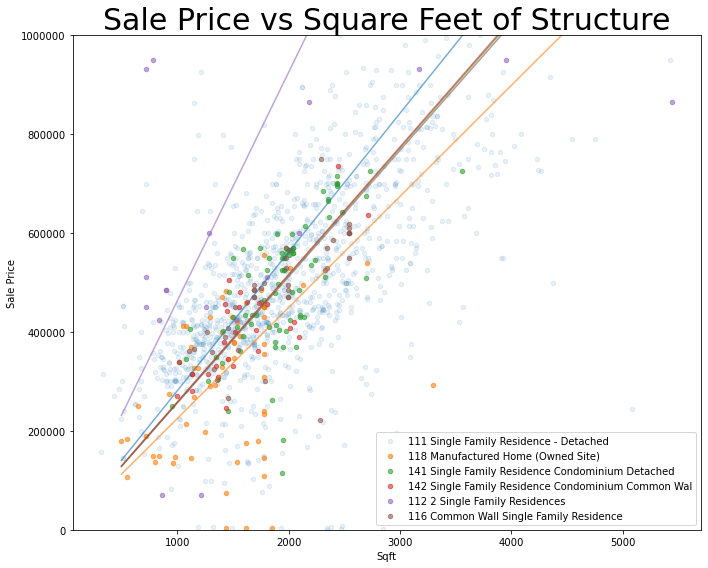

In [199]:
fig, ax = plt.subplots(figsize=(10,8))
for i, code in enumerate(codes):
    single_family[single_family["Use Code"] == code].plot.scatter('Sqft', 'Sale Price', 
                                                    color=colors[i],
                                                    alpha=(.1 if code==111 else 0.6), ax=ax,
                                                   label="{}".format(use_codes[code]))
    ax.plot([500,5000], np.array([500,5000])*p_sqft_means[code],color=colors[i], alpha=.6)
ax.set_ylim(0,1000000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
fig.tight_layout()

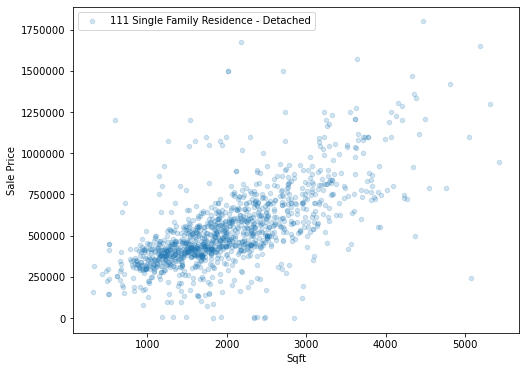

In [180]:
fig, ax = plt.subplots(figsize=(8,6))
single_family[(single_family["Use Code"] == 111) &
             (single_family["Sale Price"] < 2000000)].plot.scatter('Sqft', 'Sale Price', 
                                                color=colors[0],
                                                alpha=0.2, ax=ax,
                                               label="{}".format(use_codes[111]))
ax.ticklabel_format(style='plain');

In [182]:
single_family['Quality/Grade'].unique()

array(['Avg', 'Avg-', 'Fair', 'Good', 'Avg+', 'V Good', 'Low', 'Sub Std',
       ''], dtype=object)

### t-test for Use Codes

We want to see if Use Code has statistical significance when comparing price per square foot.  
Because there is little risk we will set $\alpha$ at 0.1

In [202]:
single_family.groupby('Use Code')['Use Code'].value_counts()

Use Code  Use Code
111       111         1216
112       112           18
116       116           40
118       118           61
141       141           82
142       142           28
Name: Use Code, dtype: int64

In [209]:
codes

array([111, 118, 141, 142, 112, 116])

In [214]:
code_ttests = []

In [215]:
for code1, code2 in combinations(codes, 2):
    s, p = stats.ttest_ind(
        single_family[(single_family['Use Code']==code1) & 
                      (single_family['price/sqft']>1)]['price/sqft'],
        single_family[(single_family['Use Code']==code2) &
                      (single_family['price/sqft']>1)]['price/sqft'])
    code_ttests.append((code1, code2, s, p))

In [ ]:
for code1, code2, s, p in code_ttests:
    

### By type

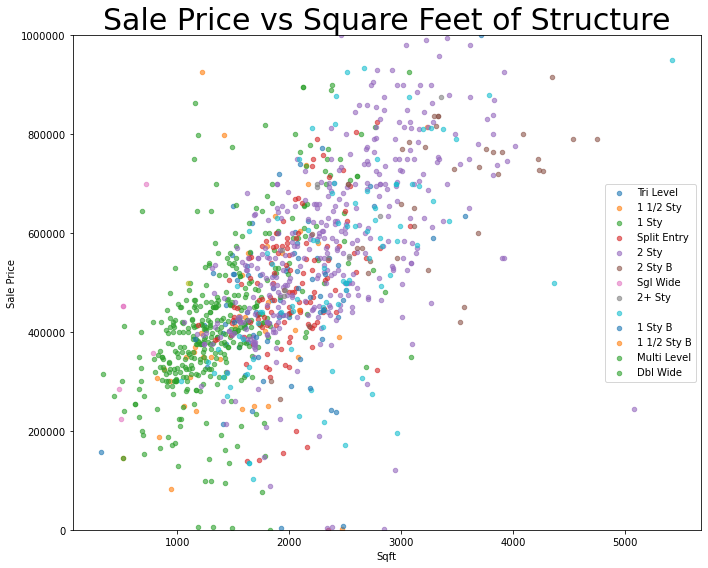

In [198]:
types = single_family[single_family["Use Code"] == 111]['Type'].unique()
fig, ax = plt.subplots(figsize=(10,8))
for i, typ in enumerate(types):
    single_family[(single_family["Use Code"] == 111) &
                  (single_family['Type']==typ) ].plot.scatter('Sqft', 'Sale Price', 
                                                    color=colors[i],
                                                    alpha=(.1 if code==111 else 0.6), ax=ax,
                                                   label="{}".format(typ))
ax.set_ylim(0,1000000)
ax.set_title('Sale Price vs Square Feet of Structure', size=30)
ax.ticklabel_format(style='plain')
fig.tight_layout()